# Google colab initialization

For Google colab uncomment these lines and run them to access your drive or try the second way (not tested)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# import sys
#
# sys.path.insert(1, r'/content/drive/My Drive/')

In [2]:
# Other try
# !git clone https://github.com/Alexanderstaehle/OM_project

In [3]:
# import sys
# sys.path.append("OM_project")

In [4]:
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from utils import ml_utils, visualization, data_loading, tf_models

In [5]:
RETRAIN_FLAG = True

In [6]:
RETRAIN_FLAG = False

In [7]:
filename_bs = lambda bs: ml_utils.path_from_filename(f'model_fixed_lr_diff_bs_{bs}', format_ = "tf")
filename_bs_lr = lambda bs, lr: ml_utils.path_from_filename(f'model_lr_{lr}_diff_bs_{bs}', format_ = "tf")

In [8]:
filename_bs_opt_sam = lambda bs, opt, sam: ml_utils.path_from_filename(f'model_fixed_lr_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_ = "tf")
filename_bs_lr_opt_sam = lambda bs, lr, opt, sam: ml_utils.path_from_filename(f'model_lr_{lr}_diff_bs_{bs}_opt_{opt}_sam_{sam}', format_ = "tf")

In [9]:
def build_and_load_sam_model_weights(train, optimizer, filename, adaptive=False, rho=0.05):
    model = tf_models.build_simple_cnn_sam(train, optimizer)
    model.load_weights(filename)
    return model

In [10]:
data_loading.initialize_env()
sns.set_theme()
color_map = sns.color_palette(as_cmap=True)
ml_utils.check_tpu_gpu()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of accelerators:  1


2022-02-21 14:02:00.118303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 14:02:00.145920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 14:02:00.146090: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-21 14:02:00.159017: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

# Different batch sizes with fixed learning rate

## without sharpness aware minimization

### SGD with Momemtum

In [11]:
models_dict_fixed = {}
batch_sizes = [32, 64, 128, 256, 512, 1024]
#batch_sizes = [32]
lr = 0.001
training_epochs = 10

In [12]:
models_by_batch_size_fixed_lr = {}

In [13]:
if not RETRAIN_FLAG: 
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)        
        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = build_and_load_sam_model_weights(train, optimizer, filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"))
        models_by_batch_size_fixed_lr[batch_size] = model

In [14]:
if RETRAIN_FLAG:
    # Need sparse categorical crossentropy since our labels are in form of integers not vectors
    for batch_size in batch_sizes:
        # Read training data
        train, validation = data_loading.load_batched_and_resized_dataset(dataset_name='MNIST', batch_size=batch_size,
                                                                          img_size=32)

        optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)
        model = tf_models.build_simple_cnn_sam(train, optimizer)

        train_callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=10,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ModelCheckpoint(
                filename_bs_opt_sam(batch_size, "SGD-MOM", "SAM"),
                monitor='val_loss',
                mode='min',
                verbose=1,
                save_best_only=True,
                save_weights_only=True
            )
            # tf.keras.callbacks.ReduceLROnPlateau(
            #     monitor="val_loss", factor=0.5,
            #     patience=3, verbose=1
            # )
        ]
        models_dict_fixed[batch_size] = ml_utils.train_model(model, train, validation, epochs=10,
                                                             extra_callbacks=train_callbacks, verbose=1)
        models_by_batch_size_fixed_lr[batch_size] = model

In [15]:
fixed_lr_state_filename = 'model_fixed_lr_diff_bs_state'

In [16]:
if RETRAIN_FLAG:
    ml_utils.save_model_state(models_dict_fixed, fixed_lr_state_filename)
else: 
    models_dict_fixed = ml_utils.load_model_state(fixed_lr_state_filename)

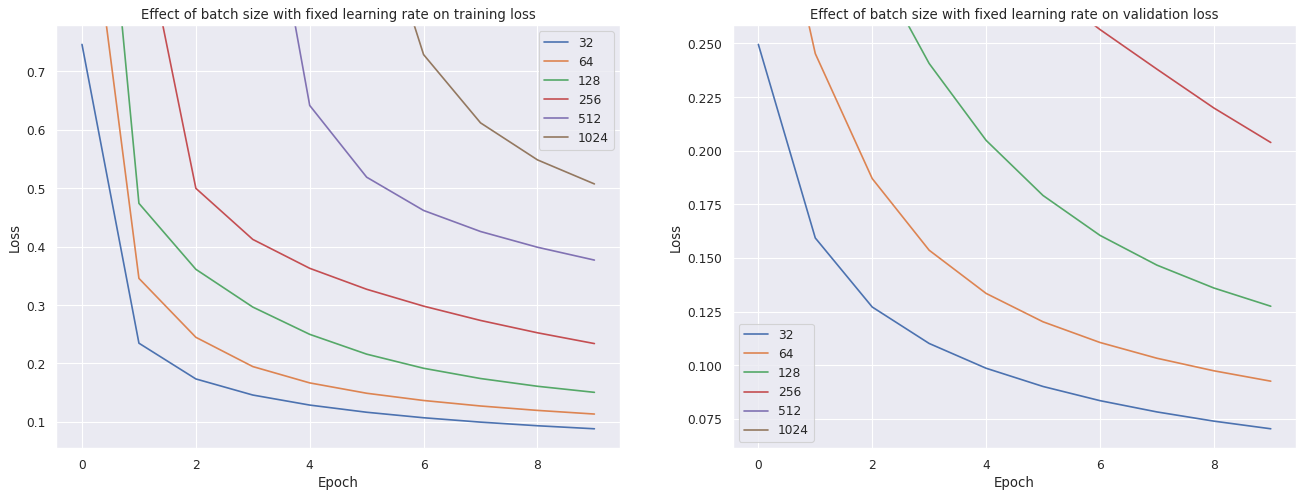

<Figure size 432x288 with 0 Axes>

In [17]:
visualization.plot_loss_by_param(models_dict_fixed, 'batch size with fixed learning rate', 'fixed_lr_diff_bs')

#### sharpness

In [18]:
sharpnesses = {}

In [19]:
for batch_size in batch_sizes:
    model = models_by_batch_size_fixed_lr[batch_size]
    
    sharpness_bs = visualization.get_sharpness(model.base_model, train)
    sharpnesses[batch_size] = sharpness_bs

2022-02-21 14:02:21.436167: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302


 1/47 [..............................] - ETA: 1:09 - loss: 0.0555 - accuracy: 0.9863

2022-02-21 14:02:21.931393: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


47/47 [==============================] - 3s 29ms/step - loss: 0.0617 - accuracy: 0.9835


47/47 [==============================] - 1s 13ms/step - loss: 0.0617 - accuracy: 0.9835
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -6.17083D-02    |proj g|=  1.58393D-02
47/47 [==============================] - 1s 11ms/step - loss: 4.0753 - accuracy: 0.3429

At iterate    1    f= -4.07533D+00    |proj g|=  3.16786D-02
  ys=-3.662E+02  -gs= 5.068E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 21.6776 - accuracy: 0.1363

At iterate    2    f= -2.16776D+01    |proj g|=  2.57641D-02
  ys=-1.258E+03  -gs= 2.557E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 30.0528 - accuracy: 0.0974

At iterate    3    f= -3.00528D+01    |proj g|=  2.43503D-02
  ys=-3.004E+02  -gs= 2.360E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 31.7900 - acc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 13ms/step - loss: 0.0859 - accuracy: 0.9762


47/47 [==============================] - 1s 14ms/step - loss: 0.0859 - accuracy: 0.9762
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -8.59337D-02    |proj g|=  1.63087D-02
47/47 [==============================] - 1s 12ms/step - loss: 5.7718 - accuracy: 0.3395

At iterate    1    f= -5.77180D+00    |proj g|=  3.26173D-02
  ys=-4.250E+02  -gs= 7.993E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 24.3626 - accuracy: 0.0976

At iterate    2    f= -2.43626D+01    |proj g|=  2.43556D-02
  ys=-1.313E+03  -gs= 2.802E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 33.3177 - accuracy: 0.0974

At iterate    3    f= -3.33177D+01    |proj g|=  2.32925D-02
  ys=-3.310E+02  -gs= 2.684E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 34.5248 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 34.9128 - accuracy: 0.0974

At iterate    9    f= -3.49128D+01    |proj g|=  2.24932D-02
47/47 [==============================] - 1s 12ms/step - loss: 34.9146 - accuracy: 0.0974

At iterate   10    f= -3.49146D+01    |proj g|=  2.01442D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786     10     12  64707     7 55569   2.014D-02  -3.491D+01
  F =  -34.914638519287109     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
47/47 [==============================] - 1s 14ms/step - loss: 0.1224 - accuracy: 0.9660


47/47 [==============================] - 1s 13ms/step - loss: 0.1224 - accuracy: 0.9660
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.22420D-01    |proj g|=  1.43887D-02
47/47 [==============================] - 1s 12ms/step - loss: 5.2283 - accuracy: 0.3641

At iterate    1    f= -5.22831D+00    |proj g|=  2.87775D-02
  ys=-2.990E+02  -gs= 8.341E+00 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 27.0600 - accuracy: 0.2305

At iterate    2    f= -2.70600D+01    |proj g|=  2.37073D-02
  ys=-1.562E+03  -gs= 3.578E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 36.1976 - accuracy: 0.1827

At iterate    3    f= -3.61976D+01    |proj g|=  2.33511D-02
  ys=-2.146E+02  -gs= 2.997E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 36.4880 - acc

47/47 [==============================] - 1s 12ms/step - loss: 0.2008 - accuracy: 0.9430
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.00810D-01    |proj g|=  1.42938D-02
47/47 [==============================] - 1s 11ms/step - loss: 9.0764 - accuracy: 0.3641

At iterate    1    f= -9.07642D+00    |proj g|=  2.85877D-02
  ys=-5.886E+02  -gs= 1.449E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 29.3578 - accuracy: 0.2922

At iterate    2    f= -2.93578D+01    |proj g|=  2.30648D-02
  ys=-1.167E+03  -gs= 4.133E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 32.8357 - accuracy: 0.2902

At iterate    3    f= -3.28357D+01    |proj g|=  2.29401D-02
  ys=-1.537E+02  -gs= 9.742E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 33.4635 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 12ms/step - loss: 33.5512 - accuracy: 0.2886

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      9     11  66043     6 58780   2.897D-03  -3.355D+01
  F =  -33.551155090332031     

ABNORMAL_TERMINATION_IN_LNSRCH                              
 1/47 [..............................] - ETA: 6s - loss: 0.2856 - accuracy: 0.9180


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 13ms/step - loss: 0.3273 - accuracy: 0.9052


47/47 [==============================] - 1s 13ms/step - loss: 0.3273 - accuracy: 0.9052
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -3.27251D-01    |proj g|=  1.40726D-02
47/47 [==============================] - 1s 12ms/step - loss: 5.4501 - accuracy: 0.4814

At iterate    1    f= -5.45014D+00    |proj g|=  2.81453D-02
  ys=-2.334E+02  -gs= 2.424E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 27.7055 - accuracy: 0.2882

At iterate    2    f= -2.77055D+01    |proj g|=  2.29962D-02
  ys=-1.496E+03  -gs= 3.274E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 11ms/step - loss: 33.4747 - accuracy: 0.2881

At iterate    3    f= -3.34747D+01    |proj g|=  2.20212D-02
  ys=-1.548E+02  -gs= 2.012E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 33.8743 - acc


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


47/47 [==============================] - 1s 13ms/step - loss: 0.4346 - accuracy: 0.8750


47/47 [==============================] - 1s 15ms/step - loss: 0.4346 - accuracy: 0.8750
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        59786     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.34563D-01    |proj g|=  1.33715D-02
47/47 [==============================] - 1s 13ms/step - loss: 6.1846 - accuracy: 0.4194

At iterate    1    f= -6.18458D+00    |proj g|=  2.67429D-02
  ys=-1.453E+02  -gs= 2.618E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 26.3559 - accuracy: 0.3669

At iterate    2    f= -2.63559D+01    |proj g|=  2.32633D-02
  ys=-9.426E+02  -gs= 5.123E+02 BFGS update SKIPPED
47/47 [==============================] - 1s 13ms/step - loss: 30.0745 - accuracy: 0.3753

At iterate    3    f= -3.00745D+01    |proj g|=  2.19889D-02
  ys=-1.834E+02  -gs= 9.703E+01 BFGS update SKIPPED
47/47 [==============================] - 1s 12ms/step - loss: 30.4812 - acc


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


47/47 [==============================] - 1s 11ms/step - loss: 30.6511 - accuracy: 0.3755



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
59786      7      9  68357     5 58571   2.005D-02  -3.065D+01
  F =  -30.651134490966797     

ABNORMAL_TERMINATION_IN_LNSRCH                              


In [20]:
sharpnesses

{32: 3007.9336597843794,
 64: 3207.258724366312,
 128: 3257.250909611615,
 256: 2777.3196608178755,
 512: 2547.6338695159347,
 1024: 2106.3211791202402}

- loss curve
- val loss curve
- final train and val loss (best) 
- sharpness of the minimizers 
- distance from initial weights

- training time
- training time per epoch 
- epochs needed to converge 
- parallelization 
- training time times sharpness

### ADAM

## with sharpness aware minimization

### SGD with Momentum + SAM 

### SGD with Momentum + ASAM

### ADAM + SAM 

### ADAM + ASAM

# Different batch sizes with linear increasing learning rate

In [ ]:
learning_rates = [0.001, 0.002, 0.004, 0.008, 0.016, 0.032]